In [35]:
# imports / libraries used
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [36]:
# load data and make sure we have data for everything

demo_data = pd.read_csv('Census_Data_Prop.csv')
demo_data = demo_data.dropna()

vibe_data = pd.read_csv('Text_Data.csv')
vibe_data = vibe_data.dropna()

In [37]:
# merge demo and vibe data

placehold_demo2 = demo_data
placehold_demo2['State'] = placehold_demo2['State'].str.strip().str.lower()
placehold_demo2['City'] = placehold_demo2['City'].str.strip().str.lower()
placehold_demo2['Neighborhood'] = placehold_demo2['Neighborhood'].str.strip().str.lower()

placehold_text2 = vibe_data
placehold_text2['State'] = placehold_text2['State'].str.strip().str.lower()
placehold_text2['City'] = placehold_text2['City'].str.strip().str.lower()
placehold_text2['Neighborhood'] = placehold_text2['Neighborhood'].str.strip().str.lower()

all_data = pd.merge(placehold_demo2, placehold_text2, on=("State", "City", "Neighborhood"))

Demographic Clusters

In [38]:
# preprocess demographic data

# keep columns we need - demographic
numerical_data = demo_data.iloc[:, 4:]
numerical_data = numerical_data.astype(float)

# scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)
scaled_data = np.nan_to_num(scaled_data, nan=0.0)

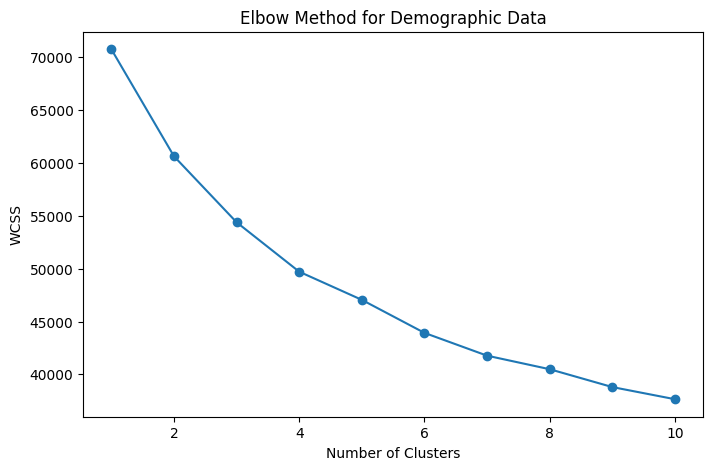

In [39]:
# perform k-means clustering - evaluate several k values
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# review elbow graph to determine optimal k
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Demographic Data")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [40]:
# run k-means with optimal k and save clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

demo_data["Cluster_Demo"] = clusters

In [41]:
# determine which neighborhoods are closest together within a cluster

def find_closest_demo_neighborhood_cluster(city1, neighborhood1, city2, df, optimal_k):
    city1 = city1.strip().lower()
    neighborhood1 = neighborhood1.strip().lower()
    city2 = city2.strip().lower()

    # Normalize DataFrame columns
    df["City_norm"] = df["City"].str.strip().str.lower()
    df["Neighborhood_norm"] = df["Neighborhood"].str.strip().str.lower()

    # Filter data for City #1
    city1_data = df[df["City_norm"] == city1]
    if city1_data.empty:
        raise ValueError(f"No data found for city '{city1}'.")

    # Set NaN values to 0 for city1_data
    city1_data = city1_data.fillna(0)

    # Filter data for City #2
    city2_data = df[df["City_norm"] == city2]
    if city2_data.empty:
        raise ValueError(f"No data found for city '{city2}'.")

    # Set NaN values to 0 for city2_data
    city2_data = city2_data.fillna(0)

    # Get data for the specified neighborhood in City #1
    neighborhood1_data = city1_data[city1_data["Neighborhood_norm"] == neighborhood1]
    if neighborhood1_data.empty:
        raise ValueError(f"No data found for neighborhood '{neighborhood1}' in city '{city1}'.")

    # Extract cluster label for the neighborhood in City #1
    neighborhood1_cluster = neighborhood1_data["Cluster_Demo"].iloc[0]

    # Filter neighborhoods in City #2 that are in the same cluster as neighborhood1
    city2_in_same_cluster = city2_data[city2_data["Cluster_Demo"] == neighborhood1_cluster]

    # Ensure numeric data for Euclidean distance computation
    numeric_neighborhood1_data = neighborhood1_data.select_dtypes(include=[np.number])
    numeric_city2_same_cluster = city2_in_same_cluster.select_dtypes(include=[np.number])

    if not numeric_city2_same_cluster.empty:
        # Compute Euclidean distances within the same cluster
        distances = euclidean_distances(numeric_neighborhood1_data, numeric_city2_same_cluster)

        # Find the index of the closest neighborhood within the same cluster
        closest_idx = np.argmin(distances)
        return city2_in_same_cluster.iloc[closest_idx]["Neighborhood"]
    else:
        # If no neighborhoods are in the same cluster, use KNN without clusters
        numeric_city2_data = city2_data.select_dtypes(include=[np.number])
        distances = euclidean_distances(numeric_neighborhood1_data, numeric_city2_data)

        # Find the index of the closest neighborhood in City #2
        closest_idx = np.argmin(distances)
        return city2_data.iloc[closest_idx]["Neighborhood"]

Vibe Clusters

In [42]:
# keep columns we need - vibe, activities
text_data = vibe_data.iloc[:, 3:]

# generate embeddings for the data with Sentence-Bert since we have full sentences and need context
model = SentenceTransformer('all-MiniLM-L6-v2')

text_embeddings = {}

for col in text_data.columns:
    col_texts = text_data[col].astype(str).tolist()
    text_embeddings[col] = model.encode(col_texts)
    print(f"Generated embeddings for '{col}', shape: {text_embeddings[col].shape}")

# combine embeddings from both columns so both can be used in clustering
all_embeddings = np.hstack([text_embeddings['Vibe'], text_embeddings['Activities']])
print(f"Combined embeddings shape: {all_embeddings.shape}")

# standardize the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(all_embeddings)

Generated embeddings for 'Vibe', shape: (1350, 384)
Generated embeddings for 'Activities', shape: (1350, 384)
Combined embeddings shape: (1350, 768)


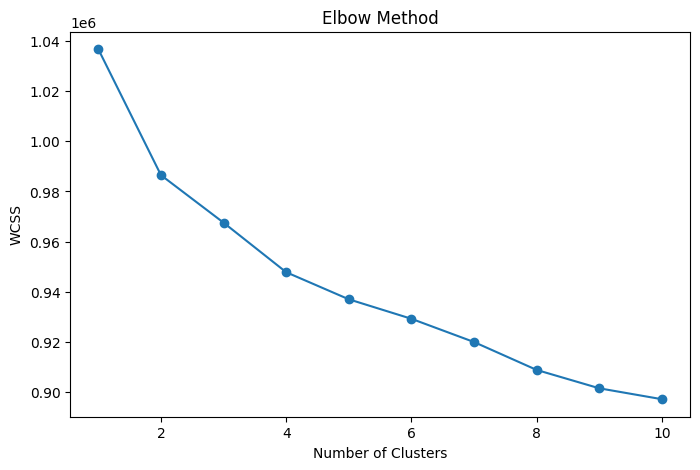

In [43]:
# perform k-means clustering - evaluate several k values
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)
    wcss.append(kmeans.inertia_)

# review elbow graph to determine optimal k
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [44]:
# run k-means with optimal k and save clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_embeddings)
vibe_data["Cluster_Vibe"] = clusters

In [45]:
# determine which neighborhoods are closest together within a cluster
def find_closest_text_neighborhood_cluster(city1, neighborhood1, city2, df, optimal_k):
    # normalize city and neighborhood data
    city1 = city1.strip().lower()
    neighborhood1 = neighborhood1.strip().lower()
    city2 = city2.strip().lower()

    df["City_norm"] = df["City"].str.strip().str.lower()
    df["Neighborhood_norm"] = df["Neighborhood"].str.strip().str.lower()

    ### filter what data we are actually looking at (based on user input) and clean (NaN --> 0)

    # filter city 1 data
    city1_data = df[df["City_norm"] == city1]
    if city1_data.empty:
        raise ValueError(f"No data found for city '{city1}'.")

    # set NaN values to 0
    city1_data = city1_data.fillna(0)

    # filter city 2 data
    city2_data = df[df["City_norm"] == city2]
    if city2_data.empty:
        raise ValueError(f"No data found for city '{city2}'.")

    # set NaN values to 0
    city2_data = city2_data.fillna(0)

    ### get data for neighborhood1
    neighborhood1_data = city1_data[city1_data["Neighborhood_norm"] == neighborhood1].iloc[:, 4:]
    if neighborhood1_data.empty:
        raise ValueError(f"No data found for neighborhood '{neighborhood1}' in city '{city1}'.")

    # get cluster labels for neighborhood1
    neighborhood1_cluster = city1_data[city1_data["Neighborhood_norm"] == neighborhood1]["Cluster_Vibe"].iloc[0]

    # extract the vibe and activities columns for embedding for neighborhood1
    neighborhood1_vibe = city1_data[city1_data["Neighborhood_norm"] == neighborhood1]["Vibe"].values[0]
    neighborhood1_activities = city1_data[city1_data["Neighborhood_norm"] == neighborhood1]["Activities"].values[0]

    # perform embedding for neighboorhood1
    model = SentenceTransformer('all-MiniLM-L6-v2')
    neighborhood1_vibe_embedding = model.encode([neighborhood1_vibe])[0]
    neighborhood1_activities_embedding = model.encode([neighborhood1_activities])[0]

    # combine embeddings for neighboorhood1
    neighborhood1_combined_embedding = np.concatenate([neighborhood1_vibe_embedding, neighborhood1_activities_embedding])

    # extract data from city2 that is in neighborhood1 cluster
    city2_in_same_cluster = city2_data[city2_data["Cluster_Vibe"] == neighborhood1_cluster]

    if not city2_in_same_cluster.empty:

        # extract the vibe and activities columns for embedding for city2
        city2_vibes = city2_in_same_cluster["Vibe"].tolist()
        city2_activities = city2_in_same_cluster["Activities"].tolist()

        # perform embedding for city2
        city2_vibe_embeddings = model.encode(city2_vibes)
        city2_activities_embeddings = model.encode(city2_activities)

        # combine embeddings for city2
        city2_combined_embeddings = np.concatenate([city2_vibe_embeddings, city2_activities_embeddings], axis=1)

        # compute distances between the neighborhood1 embeddings and city2 embeddings
        distances = euclidean_distances([neighborhood1_combined_embedding], city2_combined_embeddings)

        # find and return closest neighborhood in city2
        closest_idx = np.argmin(distances)
        return city2_in_same_cluster.iloc[closest_idx]["Neighborhood"]
    else:
        print("No neighborhoods found in the same cluster as neighborhood1 in city2.")
        # use KNN without clusters if no neighborhoods from city2 in the same cluster as neighborhood1
        city2_text = city2_data.iloc[:, 4:]
        city2_text = city2_data.iloc[:, :-2]
        distances = euclidean_distances(neighborhood1_data, city2_text)

        # find and return closest neighborhood in city2
        closest_idx = np.argmin(distances)
        return city2_data.iloc[closest_idx]["Neighborhood"]

Nearest Neighbors - All Data

In [46]:
def find_nearest_neighborhood(city1, neighborhood1, city2, df):
    # Normalize city and neighborhood data
    city1 = city1.strip().lower()
    neighborhood1 = neighborhood1.strip().lower()
    city2 = city2.strip().lower()

    # Normalize columns in the DataFrame
    df["City_norm"] = df["City"].str.strip().str.lower()
    df["Neighborhood_norm"] = df["Neighborhood"].str.strip().str.lower()

    # Filter City 1 data
    city1_data = df[df["City_norm"] == city1]
    if city1_data.empty:
        raise ValueError(f"No data found for city '{city1}'.")
    city1_data = city1_data.fillna(0)

    # Filter City 2 data
    city2_data = df[df["City_norm"] == city2]
    if city2_data.empty:
        raise ValueError(f"No data found for city '{city2}'.")
    city2_data = city2_data.fillna(0)

    # Get data for the specified neighborhood in City 1
    neighborhood1_data = city1_data[city1_data["Neighborhood_norm"] == neighborhood1]
    if neighborhood1_data.empty:
        raise ValueError(f"No data found for neighborhood '{neighborhood1}' in city '{city1}'.")

    # Initialize SentenceTransformer for embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Identify numeric and text columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    text_cols = ["Vibe", "Activities"]

    # Embed text data for neighborhood1
    neighborhood1_embeddings = []
    for col in text_cols:
        if col in neighborhood1_data.columns:
            text = neighborhood1_data[col].values[0]
            neighborhood1_embeddings.append(model.encode([text])[0])
    neighborhood1_combined_embedding = np.concatenate(neighborhood1_embeddings) if neighborhood1_embeddings else np.array([])

    # Embed text data for city2
    city2_embeddings = []
    for col in text_cols:
        if col in city2_data.columns:
            city2_texts = city2_data[col].tolist()
            city2_embeddings.append(model.encode(city2_texts))
    city2_combined_embeddings = np.concatenate(city2_embeddings, axis=1) if city2_embeddings else np.empty((len(city2_data), 0))

    # Standardize numerical data
    if not numerical_cols.empty:
        scaler = StandardScaler()
        city1_numerical = scaler.fit_transform(neighborhood1_data[numerical_cols])
        city2_numerical = scaler.transform(city2_data[numerical_cols])
    else:
        city1_numerical = np.empty((1, 0))
        city2_numerical = np.empty((len(city2_data), 0))

    # Combine text embeddings and numerical data
    neighborhood1_combined = np.concatenate([neighborhood1_combined_embedding, city1_numerical[0]])
    city2_combined = np.hstack([city2_combined_embeddings, city2_numerical])

    # Compute distances
    distances = euclidean_distances([neighborhood1_combined], city2_combined)

    # Find the index of the closest neighborhood
    closest_idx = np.argmin(distances)
    return city2_data.iloc[closest_idx]["Neighborhood"]


Hard Voting on Demo, Text, and all Clusters

In [47]:
def hard_vote(neigh1, neigh2, neigh3):
  if (neigh1 == neigh2 == neigh3):
    return neigh1
  elif (neigh2 == neigh3):
    return neigh2
  elif (neigh1 == neigh2):
    return neigh1
  elif (neigh1 == neigh3):
    return neigh1
  else:
    return neigh1

Evaluate - Test it out !!!

In [52]:
city1 = "Boston"
neighborhood1 = "Back Bay"
city2 = "New York City"

demo_neighborhood = find_closest_demo_neighborhood_cluster(city1, neighborhood1, city2, demo_data, optimal_k)
print("Closest demo neighborhood:", demo_neighborhood)

vibe_neighborhood = find_closest_text_neighborhood_cluster(city1, neighborhood1, city2, vibe_data, optimal_k)
print("Closest vibe neighborhood:", vibe_neighborhood)

knn_neighborhood = find_nearest_neighborhood(city1, neighborhood1, city2, all_data)
print("Nearest neighborhood:", knn_neighborhood)

final_neighborhood = hard_vote(knn_neighborhood, demo_neighborhood, vibe_neighborhood)
print("True nearest neighborhood (via hard vote):", knn_neighborhood)

Closest demo neighborhood: chelsea and clinton
Closest vibe neighborhood: upper east side
Nearest neighborhood: chelsea and clinton
True nearest neighborhood (via hard vote): chelsea and clinton
